In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "../DATA/train.csv"  # your injected catalog :contentReference[oaicite:0]{index=0}
df = pd.read_csv(csv_path)

# Required columns in this file: "SNR" (estimated) and "stack_snr"
x_col = "SNR"
y_col = "stack_snr"

# Clean
d = df[[x_col, y_col, "physical_filter", "trail_length", "stack_detection"]].copy()
d = d[d["stack_detection"]==True]
d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=[x_col, y_col])
d = d[(d[x_col] > 0) & (d[y_col] > 0)]  # SNRs should be positive

x = d[x_col].to_numpy()
y = d[y_col].to_numpy()

good_filter = y<15
x = x[good_filter]
y = y[good_filter]


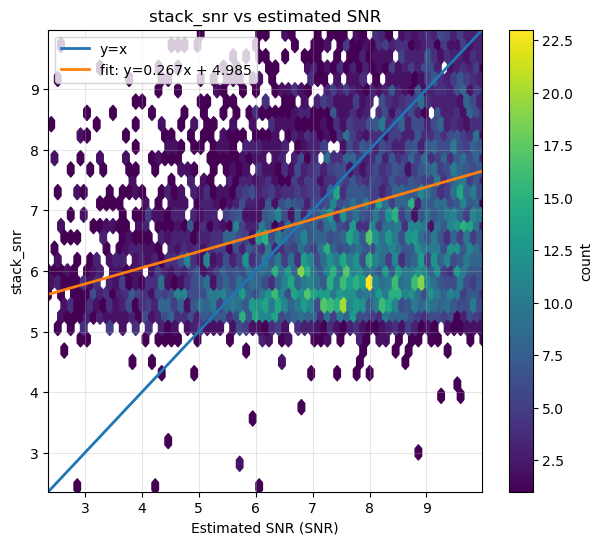

In [2]:
xmin, xmax = np.percentile(x, [0.5, 99.5])
ymin, ymax = np.percentile(y, [0.5, 99.5])

# Fit y = a*x + b
a, b = np.polyfit(x, y, deg=1)

plt.figure(figsize=(7, 6))
hb = plt.hexbin(x, y, gridsize=70, mincnt=1)
plt.colorbar(hb, label="count")

xx = np.linspace(xmin, xmax, 200)
plt.plot(xx, xx, linewidth=2, label="y=x")
plt.plot(xx, a*xx + b, linewidth=2, label=f"fit: y={a:.3f}x + {b:.3f}")

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel("Estimated SNR (SNR)")
plt.ylabel("stack_snr")
plt.title("stack_snr vs estimated SNR")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


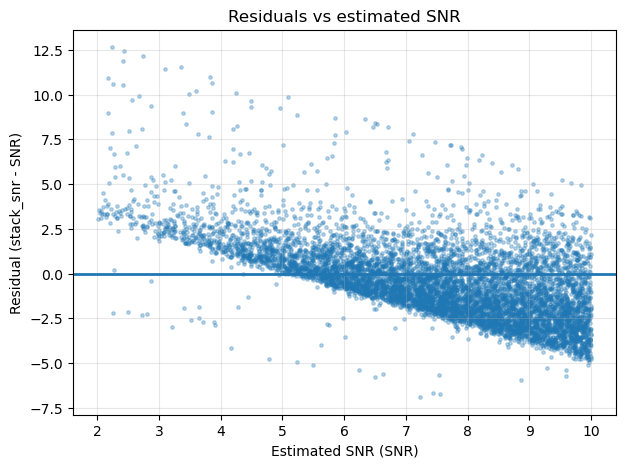

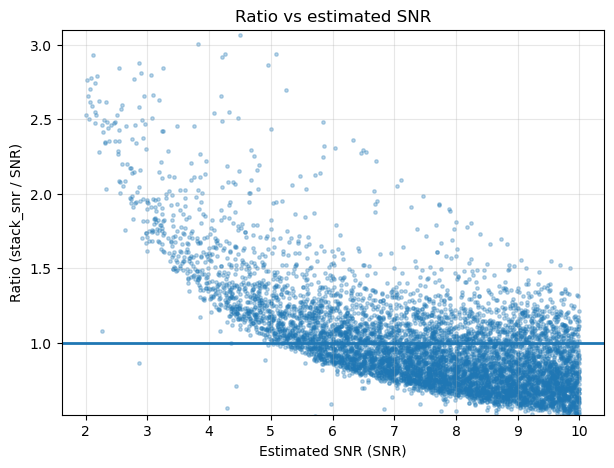

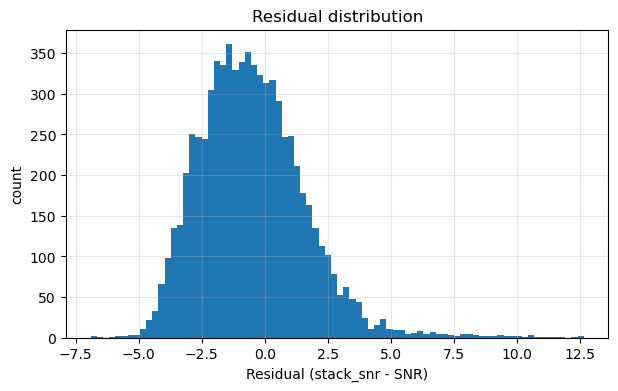

In [3]:
res = y - x
ratio = y / x

fig = plt.figure(figsize=(7, 5))
plt.scatter(x, res, s=6, alpha=0.3)
plt.axhline(0.0, linewidth=2)
plt.xlabel("Estimated SNR (SNR)")
plt.ylabel("Residual (stack_snr - SNR)")
plt.title("Residuals vs estimated SNR")
plt.grid(True, alpha=0.3)
plt.show()

fig = plt.figure(figsize=(7, 5))
plt.scatter(x, ratio, s=6, alpha=0.3)
plt.axhline(1.0, linewidth=2)
plt.xlabel("Estimated SNR (SNR)")
plt.ylabel("Ratio (stack_snr / SNR)")
plt.title("Ratio vs estimated SNR")
plt.ylim(np.percentile(ratio, 0.5), np.percentile(ratio, 99.5))
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(res, bins=80)
plt.xlabel("Residual (stack_snr - SNR)")
plt.ylabel("count")
plt.title("Residual distribution")
plt.grid(True, alpha=0.3)
plt.show()


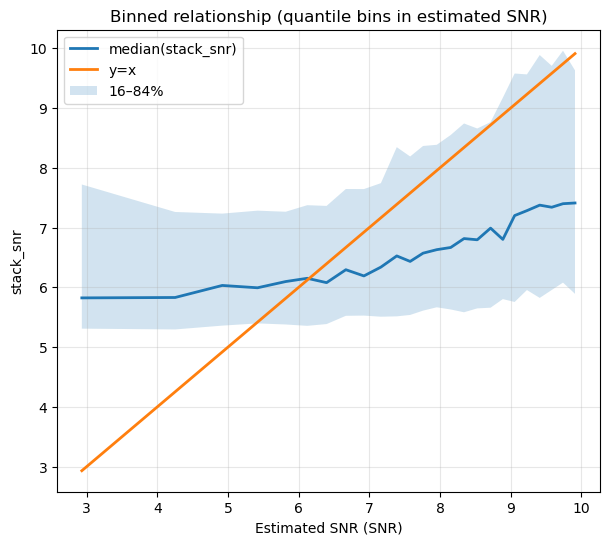

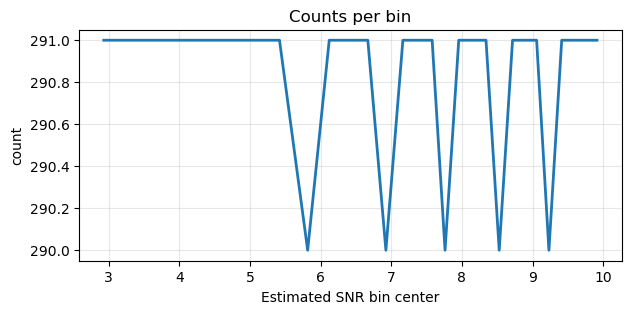

In [4]:
def binned_quantiles(x, y, bins=20, q=(0.16, 0.50, 0.84)):
    edges = np.quantile(x, np.linspace(0, 1, bins + 1))
    # avoid duplicate edges when x has many repeated values
    edges = np.unique(edges)
    if len(edges) < 3:
        raise ValueError("Not enough unique bin edges; reduce bins.")

    centers = 0.5 * (edges[:-1] + edges[1:])
    qs = {qq: np.full(len(centers), np.nan) for qq in q}
    counts = np.zeros(len(centers), dtype=int)

    for i in range(len(centers)):
        m = (x >= edges[i]) & (x < edges[i+1]) if i < len(centers)-1 else (x >= edges[i]) & (x <= edges[i+1])
        yi = y[m]
        counts[i] = yi.size
        if yi.size:
            for qq in q:
                qs[qq][i] = np.quantile(yi, qq)
    return centers, counts, qs

cent, cnt, qs = binned_quantiles(x, y, bins=25)

plt.figure(figsize=(7, 6))
plt.plot(cent, qs[0.50], linewidth=2, label="median(stack_snr)")
plt.plot(cent, cent, linewidth=2, label="y=x")
plt.fill_between(cent, qs[0.16], qs[0.84], alpha=0.2, label="16–84%")

plt.xlabel("Estimated SNR (SNR)")
plt.ylabel("stack_snr")
plt.title("Binned relationship (quantile bins in estimated SNR)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(cent, cnt, linewidth=2)
plt.xlabel("Estimated SNR bin center")
plt.ylabel("count")
plt.title("Counts per bin")
plt.grid(True, alpha=0.3)
plt.show()


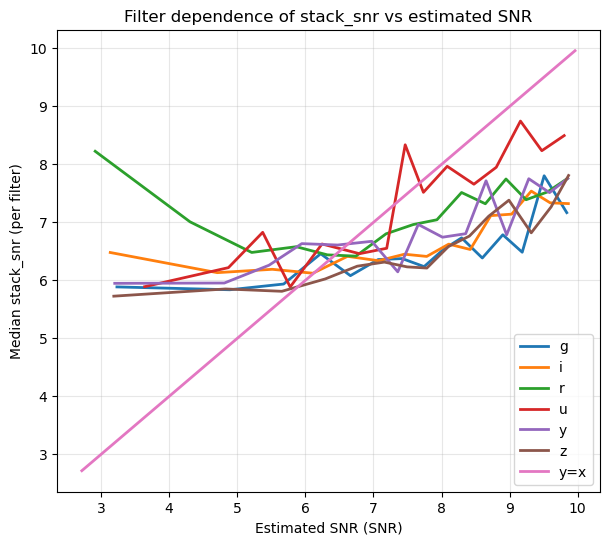

In [5]:
if "physical_filter" in d.columns:
    filters = sorted([f for f in d["physical_filter"].dropna().unique()])

    plt.figure(figsize=(7, 6))
    for f in filters:
        dd = d[d["physical_filter"] == f]
        if len(dd) < 200:
            continue
        xf = dd[x_col].to_numpy()
        yf = dd[y_col].to_numpy()
        cent_f, _, qs_f = binned_quantiles(xf, yf, bins=15)
        plt.plot(cent_f, qs_f[0.50], linewidth=2, label=str(f))

    xx = np.linspace(np.percentile(x, 1), np.percentile(x, 99), 200)
    plt.plot(xx, xx, linewidth=2, label="y=x")

    plt.xlabel("Estimated SNR (SNR)")
    plt.ylabel("Median stack_snr (per filter)")
    plt.title("Filter dependence of stack_snr vs estimated SNR")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


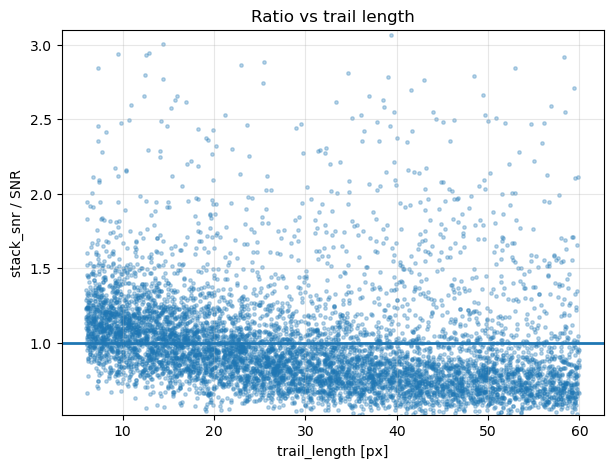

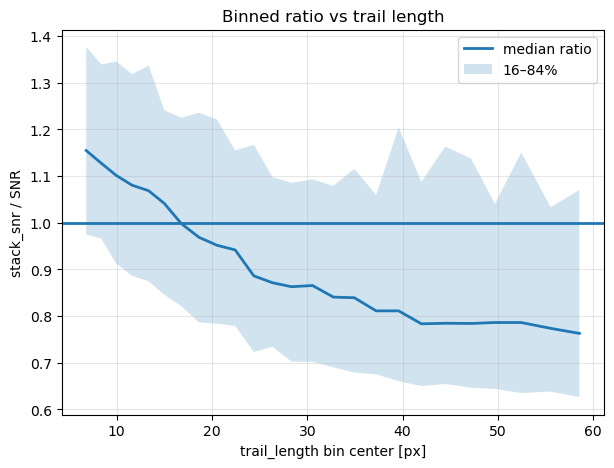

In [6]:
if "trail_length" in d.columns:
    L = d["trail_length"].to_numpy()[good_filter]
    ratio = y / x

    plt.figure(figsize=(7, 5))
    plt.scatter(L, ratio, s=6, alpha=0.3)
    plt.axhline(1.0, linewidth=2)
    plt.xlabel("trail_length [px]")
    plt.ylabel("stack_snr / SNR")
    plt.title("Ratio vs trail length")
    plt.ylim(np.percentile(ratio, 0.5), np.percentile(ratio, 99.5))
    plt.grid(True, alpha=0.3)
    plt.show()

    # binned by trail length (quantile bins)
    centL, cntL, qsL = binned_quantiles(L, ratio, bins=25)
    plt.figure(figsize=(7, 5))
    plt.plot(centL, qsL[0.50], linewidth=2, label="median ratio")
    plt.fill_between(centL, qsL[0.16], qsL[0.84], alpha=0.2, label="16–84%")
    plt.axhline(1.0, linewidth=2)
    plt.xlabel("trail_length bin center [px]")
    plt.ylabel("stack_snr / SNR")
    plt.title("Binned ratio vs trail length")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


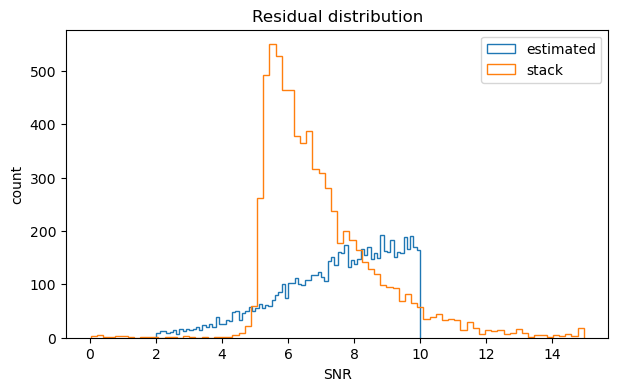

In [12]:
plt.figure(figsize=(7, 4))
plt.hist(x, bins=80, histtype="step", label="estimated")
plt.hist(y, bins=80, histtype="step", label="stack")
plt.xlabel("SNR")
plt.ylabel("count")
plt.title("Residual distribution")
plt.legend()
plt.show()